In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## Какая проблема?
Защитить свой шаттл.

## Оптимальное решение

Мы будем искать кластеры по окружностям, так как считаем, что наше оружение эффективно только в определенном радиусе.

In [2]:
df = pd.read_csv(
    "data/Ship game.csv",
    sep=";",
    names=["ship", "x", "y", "z"],
    usecols=range(4),
    skiprows=1,
)

In [3]:
df

,ship,x,y,z
0,You,15,15,15
1,Shuttle,10,10,10
2,CSM_1,200,150,150
3,CSM_2,210,130,140
4,CSM_3,205,120,135
5,CSM_4,205,130,135
6,CSM_5,205,50,50
7,CSM_6,205,65,50
8,CSM_7,210,50,70
9,CSM_8,200,30,50


Наши предположения:
1. Оружие поражает всех в радиусе `RADIUS_DAMAGE`
2. За одно мгновение можно поразить `NUM_TARGETS`
3. Само положение шаттла или корабля игнорируется

Критерий качества кластеризации: максимальное кол-во противников, которые могут быть поражены с учетом вышеописанных констант.

In [4]:
RADIUS_DAMAGE = 10
NUM_TARGETS = 2
# кол-во
N_ROLLS = 20

Координаты противников:

In [5]:
coords = df.iloc[2:, 1:].to_numpy()

In [6]:
coords

array([[200, 150, 150],
       [210, 130, 140],
       [205, 120, 135],
       [205, 130, 135],
       [205,  50,  50],
       [205,  65,  50],
       [210,  50,  70],
       [200,  30,  50],
       [100,  45,  50],
       [ 45, 100,  92]])

In [7]:
def distance_to_edges(coords, edge):
    return np.linalg.norm(coords - edge, axis=1)

In [8]:
def closest_edge(coords, edge, include=None):
    r = distance_to_edges(coords, edge)
    r[r == 0] = np.inf
    if include:
        for idx_exl in set(range(coords.shape[0])) - include:
            r[idx_exl] = np.inf
    idx_closest = np.argmin(r)
    return idx_closest, r[idx_closest]

In [9]:
closest_edge(coords, 1)

(8, 118.90332207301863)

In [10]:
def get_edges(coords, idx):
    return np.array([coords[i] for i in idx])

In [11]:
def find_centroid(coords, idx):
    return get_edges(coords, idx).mean(axis=0)

In [12]:
def pop_random_elem_from_set(sset):
    el = random.sample(tuple(sset), 1)[0]
    sset.remove(el)
    return el

Алгоритм:
1. Находим случайную точку
2. ...

In [13]:
def score_clustering(clusters) -> int:
    """Only count matters, not distance"""
    return sum(
        [len(v) for _, v in sorted(clusters.items(), key=lambda x: -len(x[1]))][
            :NUM_TARGETS
        ]
    )

In [14]:
def find_clusters_greedy(coords, threshold):
    """Greedy. Threshold is radius."""
    clusters = {}
    available_edges = set(range(coords.shape[0]))
    current_cluster = 0
    clusters[current_cluster] = [pop_random_elem_from_set(available_edges)]

    while available_edges:  # пока есть нераспределенные противники
        cluster_center = find_centroid(coords, clusters[current_cluster])

        cl_idx, cl_dist = closest_edge(coords, cluster_center, available_edges)
        new_cluster_center = find_centroid(coords, clusters[current_cluster] + [cl_idx])

        all_distances = distance_to_edges(
            get_edges(coords, clusters[current_cluster]), new_cluster_center
        )

        if cl_dist > threshold or any(all_distances > threshold):
            # if new edge is not close or new centroid drifts too far
            current_cluster += 1
            clusters[current_cluster] = [pop_random_elem_from_set(available_edges)]
        else:  # or add edge to current cluster
            available_edges.remove(cl_idx)
            clusters[current_cluster].append(cl_idx)
    return clusters


def find_clusters(coords, threshold):
    best_clustering = None
    max_quality = 0
    for _ in range(N_ROLLS):
        cl = find_clusters_greedy(coords, threshold)
        quality = score_clustering(cl)
        if quality > max_quality:
            max_quality = quality
            best_clustering = cl
    return best_clustering

In [15]:
l = find_clusters(coords, 20)
l

{0: [2, 3, 1], 1: [8], 2: [5, 4], 3: [6], 4: [7], 5: [9], 6: [0]}

In [16]:
score_clustering(l)

5

In [17]:
threshold_quality = {}
for threshold in np.linspace(0.001, 200, 1000):
    max_quality = 0
    for _ in range(N_ROLLS):
        cl = find_clusters_greedy(coords, threshold)
        quality = score_clustering(cl)
        if quality > max_quality:
            max_quality = quality
    threshold_quality[threshold] = max_quality

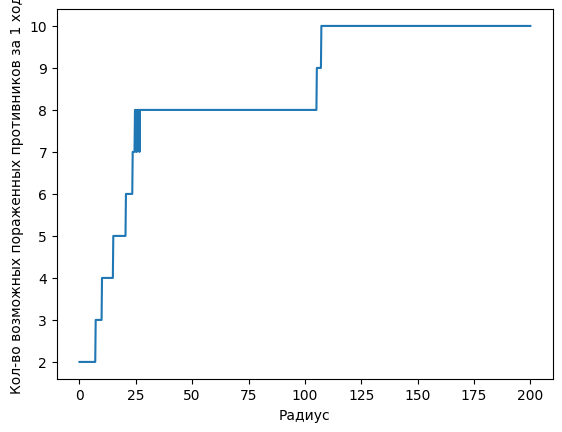

In [18]:
plt.plot(*zip(*threshold_quality.items()))
plt.xlabel("Радиус")
plt.ylabel("Кол-во возможных пораженных противников за 1 ход")
None